# Understanding $\chi^2$ 2 degrees of freedom noise

In asteroseismology, we tend to work with power-spectra, as opposed to using a timeseries. To get to a power-spectrum, we have to Fourier transform our timeseries (often done with a Lomb-Scargle transform, such as in [lightkurve](https://docs.lightkurve.org/)).

However because nothing can ever be easy, noise that is *Normal distributed in flux*, when Fourier-transformed, becomes *chi-quared two degrees of freedom distributed in power*. In this notebook I'm going to break down what chi-squared two degrees of freedom ($\chi^2_2$ for short) noise looks like, and how to fit a model to it.

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import mystyle as ms

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The equation for $\chi^2_k$ noise for a degrees of freedom $k$ is given by:

\begin{equation}
p(x | k) = \frac{1}{2^{k/2} \Gamma(k/2)}x^{k/2-1}e^{-x/2}
\end{equation}

where $\Gamma$ is the Gamma function, and $x$ here is the *relative space* over which the noise is distributed. Conveniently, the mean of the $\chi^2_k$ distribution is simply $k$, the degrees of freedom.

For $k=2$, we can simplify this equation to:
\begin{equation}
p(x | 2) =\frac{1}{2^{1} \Gamma(1)}x^{1-1}e^{-x/2} \rightarrow \frac{1}{2}e^{-x/2} 
\end{equation}

because conveniently, $\Gamma(1)$ is 1. The mean value of this probability function is 2, which is important to remember.

To see whether this equation accurately describes the noise on a Fourier transformed time-series, let's create some fake white noise and Fourier transform it to check out its properties:

In [2]:
npts = 10000
y = np.random.randn(npts)
p = np.abs(np.fft.fft(y, norm='ortho'))**2

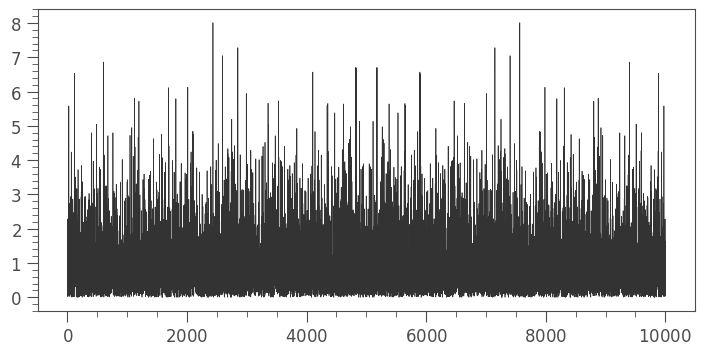

In [3]:
with plt.style.context(ms.ms):
    plt.plot(p)
    plt.show()

Anybody that looks at power spectrum for a living will instantly recognise this mess. Forunately, we think we understand how its noise properites are distributed. Let's study its properties by plotting a histogram of our data in power, compared to random points drawn from a $\chi^2_2$ distribution:

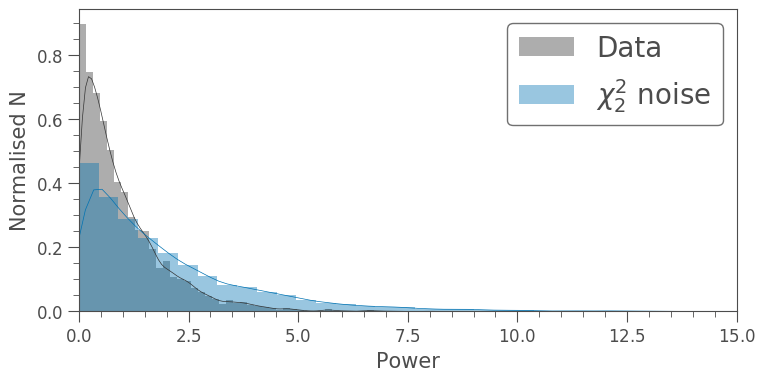

In [4]:
with plt.style.context(ms.ms):
    sns.distplot(p, label='Data')
    sns.distplot(np.random.chisquare(2., size=npts), label=r'$\chi^2_2$ noise')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

It looks like something is off here. Despite my previous assurances that power-spectrum noise is $\chi^2_2$ distributed, our data doesn't take the shape of a $\chi^2_2$ distribution at all. So what gives?

I mentioned two points earlier about the equation for the $\chi^2_2$ distribution:

\begin{equation}
p(x | 2) = \frac{1}{2}e^{-x/2} \, ,
\end{equation}

which was that $x$ was in *relative* space, and that the mean of this function is 2. In our power-spectrum, the $\chi^2_2$ noise appears *relative* to the 'limit spectrum' of the timeseries, which is what our spectrum would look like at infinite signal to noise (e.g. given an infinitely long observation time). In this case, our limit spectrum is just 1. We can check this by investigating the mean of our data:

In [5]:
print('Mean of data: {:.2f}'.format(np.mean(p)))

Mean of data: 1.00


So in order to describe the $\chi^2_2$ noise properties relative to the limit spectrum, we have to rewrite the equation as

\begin{equation}
p(x | k = 2) = \frac{1}{M}e^{-x/M} \, ,
\end{equation}

where M is our limit spectrum. We can obtain this distribution simply by dividing through our random $\chi^2_2$ by its mean (which is equal to the degrees of freedom, 2):

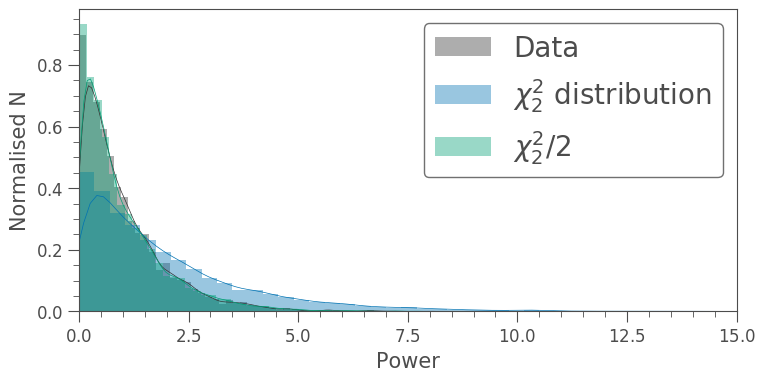

In [6]:
with plt.style.context(ms.ms):
    sns.distplot(p, label='Data')
    sns.distplot(np.random.chisquare(2., size=npts), label=r'$\chi^2_2$ distribution')
    sns.distplot(np.random.chisquare(2., size=npts)/2., label=r'$\chi^2_2 / 2$')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

Conveniently, we have now also arrived at the appropriate likelihood function for fitting a limit spectrum model to some power spectrum data. It is simply:

\begin{equation}
p(x | M) = \frac{1}{M}e^{-x/M} \, ,
\end{equation}

as before, where $x$ is our observed data and $M$ is our model. For more details, see Anderson et al. (1990), Duvall & Harvey (1986), or more modern peakbagging work such as Lund et al. (2017), Davies et al. (2016), Santos et al. (2019) etc.

## Fitting a spectrum in practice

When fitting a model to a power spectrum using a probabilistic programming tool such as [Stan](https://mc-stan.org/) or [PyMC3](https://docs.pymc.io/), it isn't straightforward to model data using a $\chi^2_2$ function, as it doesn't lend well to being applied relative to a model (as we've seen above).

Fortunately, there is a solution. The $\chi^2_k$ distribution is simply a special case of the $\Gamma$ distribution (not to be confused with the $\Gamma$ function!). It goes as follows:

\begin{equation}
p(x | \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x} .
\end{equation}

We can alreayd see some similarity between this and the $\chi^2_k$ distribution. Using specific values for $\alpha$ and $\beta$, we can directly recover the $\chi^2_2$ distribution relative to a model.

The specific substitions we want to use are $\alpha = k/2$ and $\beta = 1/M$. When substituting these into the above equation we get

\begin{equation}
p(x | \alpha = 1, \beta = 1/M) = \frac{1}{M^1\Gamma(1)}x^{1-1}e^{-x/M} \rightarrow \frac{1}{M}e^{-x/M} ,
\end{equation}

which is the likelihood function we returned above!

Just to showcase how this would work in practice, I've written a quick PyMC3 model to recover the mean of our data, which should be 1, below:

In [7]:
pm_model = pm.Model()
with pm_model:
    mean = pm.HalfNormal('mean', 100.)
    
    model = tt.zeros(len(p)) + mean
    
    like = pm.Gamma('like',alpha=1., beta=1./(model), observed=p)
    t_reg = pm.sample(tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2768.26draws/s]


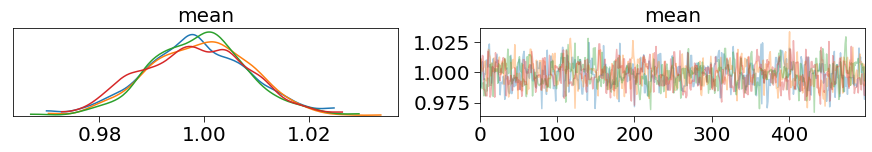

In [8]:
pm.summary(t_reg, var_names=['mean']);
pm.traceplot(t_reg, var_names=['mean']);

And we can check that we have correctly found the "limit spectrum" by dividing the data through our "model", and checking the residuals have the noise properties we expect:

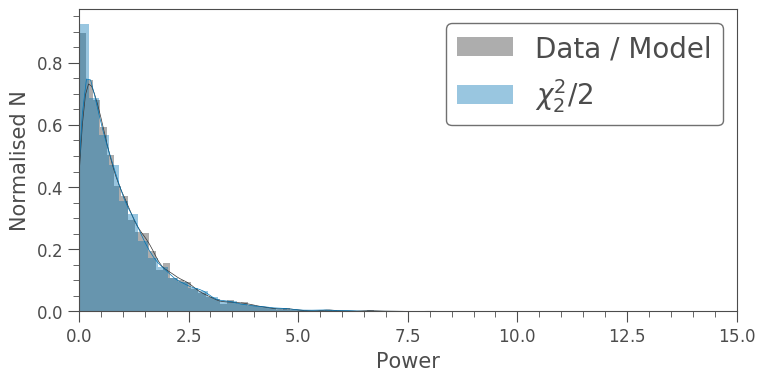

In [9]:
resb = np.median(t_reg['mean'])
mod = np.ones(len(p)) * resb

with plt.style.context(ms.ms):
    sns.distplot(p/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(2., size=npts)/2., label=r'$\chi^2_2 / 2$')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

The noise properties are as we expect them, and we have recovered our "limit spectrum" to high precision! Well done us.

## Fitting a binned power spectrum

A good asteroseismic power spectrum can be *very* long, and consequently, very computationally heavy to fit a model to. When dealing with fitting artefacts that don't require a high frequency resolution (e.g. the granulation background of a star), binning the data can dramatically reduce the computational cost while having a negligible impact on the inference of a model.

However because we can't have nice things, binning a power spectrum changes its noise properties. Let's investigate how these noise properties change, and how we can still fit a decent model to a binned power spectrum.

We're going to use a binning factor of $b = 5$, meaning that we take 5 bins of power and sum them into a new, single bin, as follows:

In [10]:
b = 5
m = int(len(p)/b)
p_bin = np.sum(p[:m*b].reshape((m, b)),axis=1)

We can see what the distribution of the new binned power looks like compared to our unbinned spectrum:

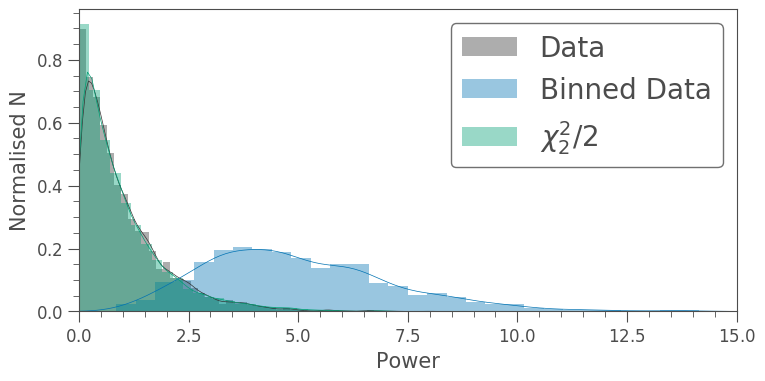

In [11]:
with plt.style.context(ms.ms):
    sns.distplot(p, label='Data')
    sns.distplot(p_bin, label='Binned Data')    
    sns.distplot(np.random.chisquare(2., size=npts)/2., label=r'$\chi^2_2 / 2$')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

In [12]:
print('Mean of the binned data: {:.2f}'.format(np.mean(p_bin)))

Mean of the binned data: 4.99


So it looks like our data has increased in power, and the noise properties have changed from something we previously understood to god knows what.

What if we try performing a fit to these data? We know that our "limit spectrum" has a value of 1. 

In [13]:
pm_model = pm.Model()
with pm_model:
    mean = pm.HalfNormal('mean', 100.)
    model = tt.zeros(len(p_bin)) + mean
    
    like = pm.Gamma('like',alpha=1., beta=1./(model), observed=p_bin)
    t_bin = pm.sample(tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3713.81draws/s]
The acceptance probability does not match the target. It is 0.7138410768287988, but should be close to 0.8. Try to increase the number of tuning steps.


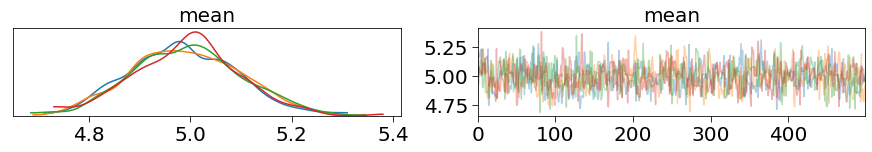

In [14]:
pm.summary(t_bin, var_names=['mean']);
pm.traceplot(t_bin, var_names=['mean']);

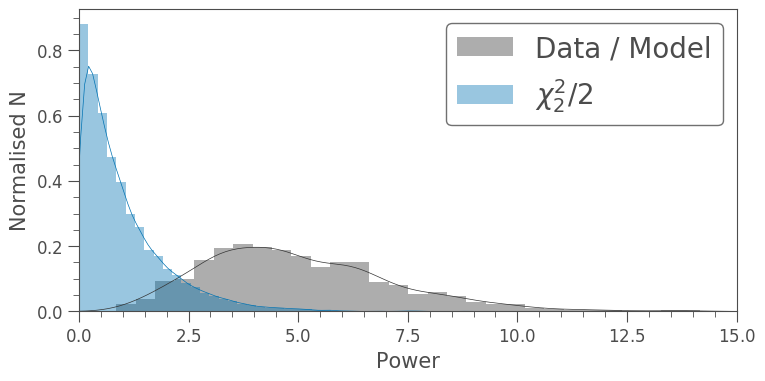

In [15]:
resb = np.median(t_reg['mean'])
mod = np.ones(len(p_bin)) * resb

with plt.style.context(ms.ms):
    sns.distplot(p_bin/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(2., size=npts)/2., label=r'$\chi^2_2 / 2$')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

It looks like the fit mean value is 5, not 1. The "residuals", of course, don't look like a $\chi^2_2$.

Now if we remember, the mean of a $\chi^2_k$ distribution is equal to $k$. The mean of our un-binned power spectrum is $k/2$. The mean of our binned power spectrum is 5. Could our binned power spectrum follow a $\chi^2_{10}$ distribution?

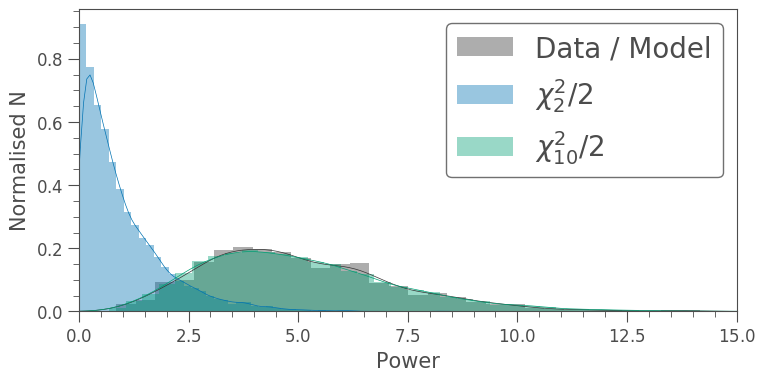

In [16]:
with plt.style.context(ms.ms):
    sns.distplot(p_bin/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(2., size=npts)/2., label=r'$\chi^2_2 / 2$')
    sns.distplot(np.random.chisquare(10., size=npts)/2., label=r'$\chi^2_{10} / 2$')    
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

Indeed it is! It's a known property of $\chi^2_2$ noise that when binning over $b$ bins, the noise statistics become $\chi^2_k$ with $k = 2b$ (Appourchaux 2004).

## So how do we model this?

If we remember from earlier, the $\chi^2_2$ distribution, is a special case of the Gamma distribution, which can be evaluated relative to a model by setting the parameters $\alpha = k/2$ and $\beta=1/M$. 

To fit a model to $\chi^2_{10}$ noise, we simply set $\alpha = 10/2$ when evaluating the Gamma distribution. We can see this by plotting a Gamma distribution with these properties on the above plot:

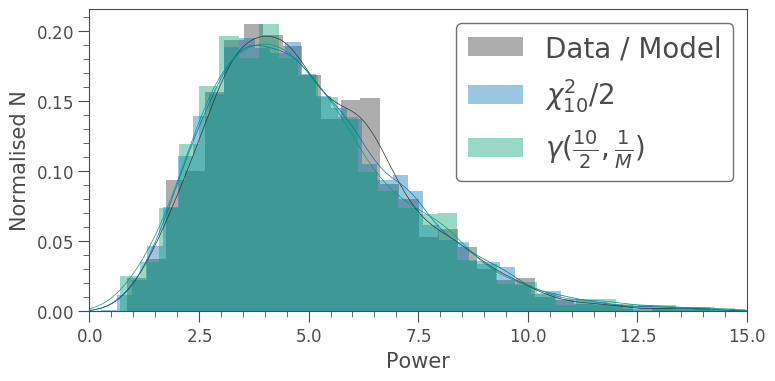

In [17]:
with plt.style.context(ms.ms):
    sns.distplot(p_bin/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(10., size=npts)/2., label=r'$\chi^2_{10} / 2$')    
    sns.distplot(np.random.gamma(10./2., 1./mod), label=r'$\gamma(\frac{10}{2}, \frac{1}{M})$')    
    
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

And consequently, we can set $\alpha$ to this value when we model our "limit spectrum".

In [18]:
pm_model = pm.Model()
with pm_model:
    mean = pm.HalfNormal('mean', 100.)
    model = tt.zeros(len(p_bin)) + mean
    
    like = pm.Gamma('like',alpha=10./2., beta=1./(model), observed=p_bin)
    t_proper = pm.sample(tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3534.19draws/s]


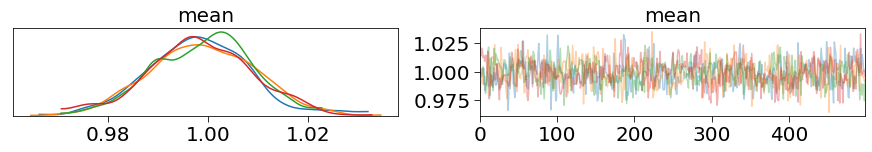

In [19]:
pm.summary(t_proper, var_names=['mean']);
pm.traceplot(t_proper, var_names=['mean']);

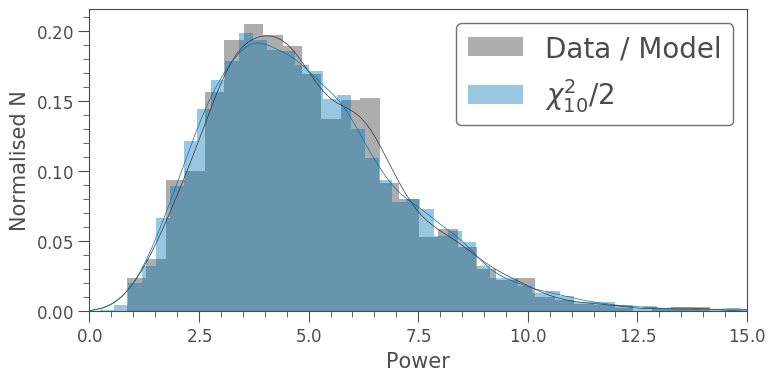

In [20]:
resb = np.median(t_proper['mean'])
mod = np.ones(len(p_bin)) * resb

with plt.style.context(ms.ms):
    sns.distplot(p_bin/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(10., size=npts)/2., label=r'$\chi^2_{10} / 2$')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

So despite the values in our binned spectrum being *nowhere* near 1, we have succesfully recovered the limit spectrum of our *unbinned* spectrum by properly treating the noise statistics.

Naturally, this applies to any model you try to fit to a power spectrum. Try going through the notebook yourself after adding some signal to the flux, and fitting it in frequency space!